In [1]:
!pip install tensorflow

In [5]:
import pandas as pd
import numpy as np
from numpy import sqrt,mean,log,diff
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf # https://github.com/ranaroussi/yfinance
import pickle
import torch # seems to be necessary to enable keras GPU usage
import tensorflow as tf
from tensorflow import keras

In [8]:
tickers_list = ['AAPL', 'WMT', 'IBM', 'TSLA']

# Fetch the data
import yfinance as yf
data = yf.download(tickers_list,'2020-1-1')['Close']
idx = data.index

# Print first 5 rows of the data
print(data.tail())

[*********************100%***********************]  4 of 4 completed

Ticker            AAPL         IBM        TSLA        WMT
Date                                                     
2025-06-02  201.699997  263.899994  342.690002  99.769997
2025-06-03  203.270004  265.200012  344.269989  99.980003
2025-06-04  202.820007  265.519989  332.049988  99.349998
2025-06-05  200.630005  266.859985  284.700012  97.959999
2025-06-06  203.919998  268.869995  295.140015  97.470001


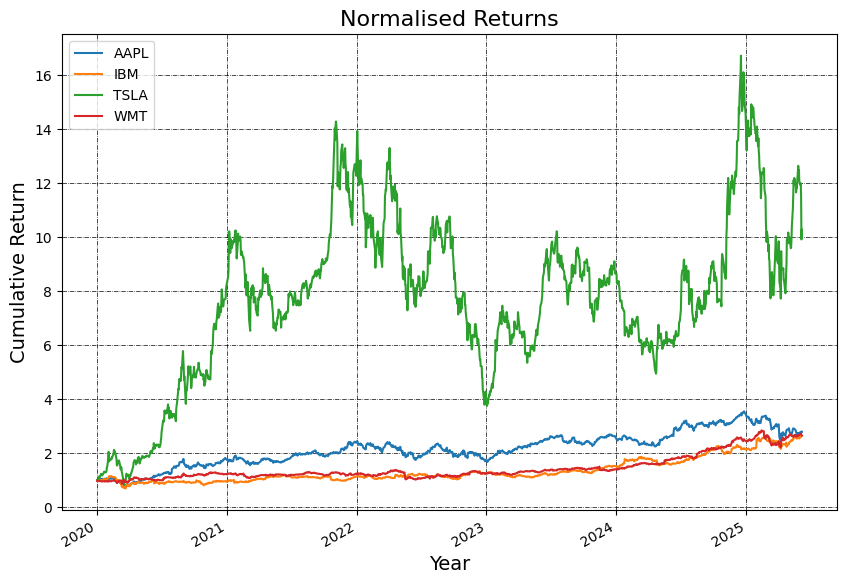

In [9]:
# Plot all the close prices
((data.pct_change()+1).cumprod()).plot(figsize=(10, 7))

# Show the legend
plt.legend()

# Define the label for the title of the figure
plt.title("Normalised Returns", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Cumulative Return', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [10]:
def getTimelagDataset(data, lag=60, forecast=5): # takes a numpy array, returns time lagged training data
    X, y, X_last = [], [], []
    for i in range(lag, data.shape[0]-forecast):
        X.append(data[i-lag:i, 0])
        y.append(data[i:i+forecast, 0])

    X, y = np.array(X), np.array(y)
    X    = np.reshape(X, (X.shape[0], X.shape[1], 1)) # one feature (price)

    return X, y

In [11]:
stockname = "TSLA"
lag = 60
n_forecast = 5

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data[[stockname]])
X, y = getTimelagDataset(data, lag, n_forecast)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

def LSTMmodel(n_forecast): # model from Moghar et al.
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(units=n_forecast))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [13]:
model = LSTMmodel(n_forecast)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=1)

with tf.device('/device:GPU:0'):
    model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1, callbacks=[earlyStopping])

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 543ms/step - loss: 0.0684 - val_loss: 0.0114
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 384ms/step - loss: 0.0072 - val_loss: 0.0104
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - loss: 0.0076 - val_loss: 0.0152
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 413ms/step - loss: 0.0064 - val_loss: 0.0096
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 399ms/step - loss: 0.0057 - val_loss: 0.0130
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 391ms/step - loss: 0.0062 - val_loss: 0.0095
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 395ms/step - loss: 0.0057 - val_loss: 0.0062
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 495ms/step - loss: 0.0046 - val_loss: 0.0082
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 414ms/step - loss: 0.0046 - val_loss: 0.0062
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step - loss: 0.0038 - val_loss: 0.0066
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 405ms/step - loss: 0.0046 - val_loss: 0.0049
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20

In [14]:
X_test = X[int(-0.2*X.shape[0]):]
y_pred = model.predict(X_test)
y_pred, y = scaler.inverse_transform(y_pred), scaler.inverse_transform(y)

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step


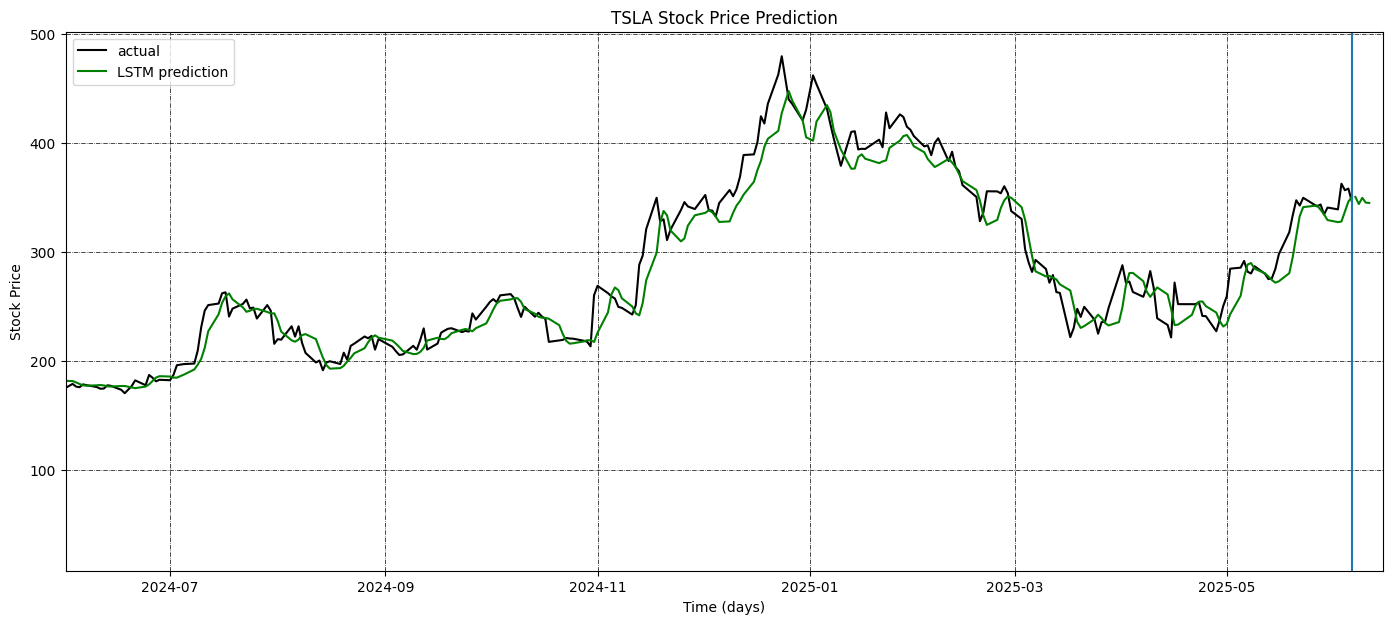

In [22]:
plt.plot(idx[-len(y[:,0]):],      y[:,0],      color='black', label='actual')
plt.plot(idx[-len(y_pred[:,0]):], y_pred[:,0], color='green', label='LSTM prediction')

# continue idx by lag - assume date format
from datetime import datetime, timedelta, date
startdate = idx[-1]
idx_forecast = idx.copy(deep=True)
for i in range(n_forecast):
    idx_forecast = idx_forecast.append(pd.Index([startdate+timedelta(days=i+1)]))

plt.plot(idx_forecast[-len(y_pred[-1]):], y_pred[-1], color='green')
plt.title(stockname+' Stock Price Prediction')
plt.xlabel('Time (days)')
plt.ylabel('Stock Price')
plt.xlim(date(2024, 6, 1), date(2025, 6, 15))
plt.axvline(x=startdate)
plt.legend()
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)

plt.gcf().set_size_inches(17, 7)
plt.show()
plt.close()